**Rocks Classifictions**

# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
# Set the style for plots
sns.set_style('darkgrid')
# Import confusion matrix and classification report for later evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Set the path for the dataset

In [2]:
path = '/kaggle/input/algerian-used-cars/dataset/DATA'
filepaths = []
labels = []

# Loop through the directories and files to get file paths and labels
for label in os.listdir(path):
    for i in os.listdir(path+"/"+label):
        filepaths.append(path+"/"+label+'/'+i)
        labels.append(label)

# Display the count of labels
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))
pd.Series(labels).value_counts()

# Save file paths and labels in a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

filepaths:  3235    labels:  3235


In [3]:
# Display the count of labels in the DataFrame
balance = df['labels'].value_counts()
print(balance)

clio                 344
megane               280
duster               280
sandero              260
volkswagen tiguan    184
picanto              178
Golf                 160
symbol               158
octavia              156
toyota corolla       150
polo                 132
hyundai i10          130
chevroulet aveo      129
hyundai tucson       128
logan                112
chevrolet spark      108
seat ibiza           100
mercedes class a      84
bmw serie 1           82
nemo citroen          80
Name: labels, dtype: int64


# Split the dataset into train, valid, and test sets

In [4]:
height = 224
width = 224
channels = 3
batch_size = 60
img_shape = (height, width, channels)
img_size = (height, width)
train_split = 0.8
test_split = 0.1

# Split the dataset

In [5]:
# Split the dataset using train_test_split
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=test_split/(1-train_split), shuffle=True, random_state=123)

# Display the sizes of train, test, and valid sets
print("Train set size:", len(train_df), "| Test set size:", len(test_df), "| Valid set size:", len(valid_df))

Train set size: 2588 | Test set size: 323 | Valid set size: 324


In [6]:
# Display the count of labels in the train set
print("Label distribution in the training set:\n", train_df['labels'].value_counts())

Label distribution in the training set:
 clio                 263
megane               233
duster               225
sandero              208
picanto              143
symbol               137
volkswagen tiguan    134
octavia              134
Golf                 129
toyota corolla       126
hyundai i10          106
polo                 105
chevroulet aveo      105
hyundai tucson        96
logan                 86
chevrolet spark       83
seat ibiza            77
bmw serie 1           67
nemo citroen          66
mercedes class a      65
Name: labels, dtype: int64


# Image Data Generator

In [7]:
# Generate train, test, and valid sets using ImageDataGenerator
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

# Create ImageDataGenerator for training set with augmentation
trgen = ImageDataGenerator(preprocessing_function=scalar, 
                           horizontal_flip=True, 
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           validation_split=0.2,
                           fill_mode='nearest')

# Create ImageDataGenerators for test and validation sets without augmentation
tvgen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = trgen.flow_from_dataframe(train_df, 
                                     x_col='filepaths', 
                                     y_col='labels', 
                                     target_size=img_size, 
                                     class_mode='categorical',
                                     color_mode='rgb', 
                                     shuffle=False, 
                                     batch_size=batch_size)

test_gen = tvgen.flow_from_dataframe(test_df, 
                                    x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size, 
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=False, 
                                    batch_size=batch_size)

valid_gen = tvgen.flow_from_dataframe(valid_df, 
                                     x_col='filepaths', 
                                     y_col='labels', 
                                     target_size=img_size, 
                                     class_mode='categorical',
                                     color_mode='rgb', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 2588 validated image filenames belonging to 20 classes.
Found 323 validated image filenames belonging to 20 classes.
Found 324 validated image filenames belonging to 20 classes.


In [8]:
FILEPATH = '/kaggle/working/Dataset/' # filepath for data
BATCH_SIZE = 64# keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)


ROUND_1_TRAINABLE_LAYERS = 0 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 10

ROUND_2_TRAINABLE_LAYERS = 38
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 10

ROUND_3_TRAINABLE_LAYERS = 74
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 10

LEARNING_RATE = 0.0001

MODEL_CHECKPOINT_FILEPATH = './Bird-Classifier-Model-Checkpoint.ckpt'

SEED = 6278 # random seed for repeatability of notebook

# Build the model 

In [9]:
# Build the model using MobileNet as the base model
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3),
                                                      include_top=False,
                                                      weights='imagenet')

# Create a sequential model
model = Sequential()

# Add MobileNet as the base model
model.add(mobilenet)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Flatten the output
model.add(Flatten())

# Add Dense layers
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

# Add the output layer with softmax activation for classification
model.add(Dense(20, activation="softmax", name="classification"))

# Set optimizer, loss function, and metrics
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Define model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode='max')

# Compile the model
model.compile(optimizer=optimizer_1, loss=loss, metrics=['accuracy'])

17235968/17225924 [==============================] - 0s 0us/step


# Train the model

In [10]:
# Train the model with the training and validation sets
hist = model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[model_checkpoint])

Epoch 1/10
44/44 [==============================] - 58s 1s/step - loss: 2.6244 - accuracy: 0.2415 - val_loss: 2.4601 - val_accuracy: 0.2870

Epoch 00001: val_accuracy improved from -inf to 0.28704, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 2/10
44/44 [==============================] - 37s 835ms/step - loss: 1.5630 - accuracy: 0.5753 - val_loss: 1.8441 - val_accuracy: 0.4660

Epoch 00002: val_accuracy improved from 0.28704 to 0.46605, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 3/10
44/44 [==============================] - 37s 835ms/step - loss: 0.8143 - accuracy: 0.7794 - val_loss: 1.1336 - val_accuracy: 0.6790

Epoch 00003: val_accuracy improved from 0.46605 to 0.67901, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 4/10
44/44 [==============================] - 37s 826ms/step - loss: 0.4650 - accuracy: 0.8706 - val_loss: 0.8142 - val_accuracy: 0.7747

Epoch 00004: val_accuracy improved from 0.67901 to 0.77469, saving model to ./Bird

# Load the best weights

In [11]:
# Load the best weights from the model checkpoint
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

# Evaluate the model

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

6/6 [==============================] - 2s 363ms/step - loss: 0.1496 - accuracy: 0.9567

The model had an accuracy score of 95.7%!!


# Plot the training and validation accuracy

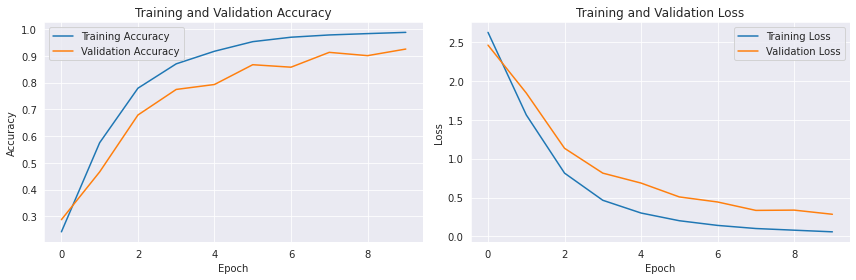

In [13]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Model Predict

In [14]:
# Get true labels for the test set
y_true_classes = test_gen.classes

# Predict the labels for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix

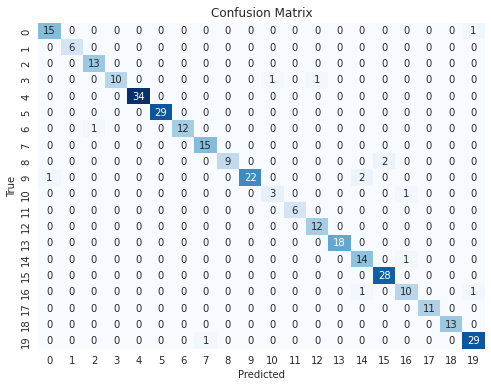

In [15]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# classification report

In [16]:
# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

# Display classification report
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       1.00      1.00      1.00         6
           2       0.93      1.00      0.96        13
           3       1.00      0.83      0.91        12
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        29
           6       1.00      0.92      0.96        13
           7       0.94      1.00      0.97        15
           8       1.00      0.82      0.90        11
           9       1.00      0.88      0.94        25
          10       0.75      0.75      0.75         4
          11       1.00      1.00      1.00         6
          12       0.92      1.00      0.96        12
          13       1.00      1.00      1.00        18
          14       0.82      0.93      0.87        15
          15       0.93      1.00      0.97        28
          16       0.83      0.83      0.83        12
  